In [1]:
#Importing necessary dependencies
import numpy as np
import pandas as pd
import sklearn.metrics
import sklearn.model_selection
import sklearn.linear_model
import sklearn.preprocessing
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, AlphaDropout
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

In [2]:
#Loading dataset
data = pd.read_csv('/content/UNSW_NB15_testing-set.csv')
test = pd.read_csv('/content/UNSW_NB15_training-set.csv')

In [3]:
data.describe()

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
count,175341.000000,175341.000000,175341.000000,175341.000000,1.753410e+05,1.753410e+05,1.753410e+05,175341.000000,175341.000000,1.753410e+05,1.753410e+05,175341.000000,175341.000000,175341.000000,175341.000000,1.753410e+05,175341.000000,175341.000000,1.753410e+05,1.753410e+05,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,1.753410e+05,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000
mean,87671.000000,1.359389,20.298664,18.969591,8.844844e+03,1.492892e+04,9.540619e+04,179.546997,79.609567,7.345403e+07,6.712056e+05,4.953000,6.948010,985.976864,88.216296,4.976254e+03,604.353826,116.257339,9.692504e+08,9.688770e+08,115.013625,0.041396,0.021020,0.020375,136.751769,124.173382,0.105982,2.144292e+03,9.306437,1.304179,6.193936,5.383538,4.206255,8.729881,0.014948,0.014948,0.133066,6.955789,9.100758,0.015752,0.680622
std,50616.731112,6.480249,136.887597,110.258271,1.747656e+05,1.436542e+05,1.654010e+05,102.940011,110.506863,1.883574e+08,2.421312e+06,66.005059,52.732999,7242.245841,987.093195,4.496585e+04,4061.043281,127.001024,1.355264e+09,1.354000e+09,126.886530,0.079354,0.043400,0.040506,204.677360,258.317056,0.776911,5.420797e+04,10.704331,0.954406,8.052476,8.047104,5.783585,10.956186,0.126048,0.126048,0.701208,8.321493,10.756952,0.124516,0.466237
min,1.000000,0.000000,1.000000,0.000000,2.800000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,28.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,43836.000000,0.000008,2.000000,0.000000,1.140000e+02,0.000000e+00,3.278614e+01,62.000000,0.000000,1.305334e+04,0.000000e+00,0.000000,0.000000,0.008000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,57.000000,0.000000,0.000000,0.000000e+00,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000
50%,87671.000000,0.001582,2.000000,2.000000,4.300000e+02,1.640000e+02,3.225807e+03,254.000000,29.000000,8.796748e+05,1.447023e+03,0.000000,0.000000,0.279733,0.006000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,73.000000,44.000000,0.000000,0.000000e+00,5.000000,1.000000,2.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,4.000000,0.000000,1.000000
75%,131506.000000,0.668069,12.000000,10.000000,1.418000e+03,1.102000e+03,1.250000e+05,254.000000,252.000000,8.888889e+07,2.784487e+04,3.000000,2.000000,55.156896,51.053000,2.513295e+03,114.990625,255.000000,1.916651e+09,1.913675e+09,255.000000,0.065481,0.023268,0.038906,100.000000,89.000000,0.000000,0.000000e+00,12.000000,2.000000,7.000000,5.000000,3.000000,12.000000,0.000000,0.000000,0.000000,9.000000,12.000000,0.000000,1.000000
max,175341.000000,59.999989,9616.000000,10974.000000,1.296523e+07,1.465555e+07,1.000000e+06,255.000000,254.000000,5.988000e+09,2.242273e+07,4803.000000,5484.000000,84371.496000,56716.824000,1.460480e+06,289388.269700,255.000000,4.294959e+09,4.294882e+09,255.000000,2.518893,2.100352,1.520884,1504.000000,1458.000000,172.000000,6.558056e+06,63.000000,6.000000,51.000000,51.000000,46.000000,65.000000,4.000000,4.000000,30.000000,60.000000,62.000000,1.000000,1.000000


In [4]:
data

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,254,1.415894e+04,8495.365234,0,0,24.295600,8.375000,30.177547,11.830604,255,621772692,2202533631,255,0.000000,0.000000,0.000000,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,252,8.395112e+03,503571.312500,2,17,49.915000,15.432865,61.426934,1387.778330,255,1417884146,3077387971,255,0.000000,0.000000,0.000000,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,252,1.572272e+03,60929.230470,1,6,231.875571,102.737203,17179.586860,11420.926230,255,2116150707,2963114973,255,0.111897,0.061458,0.050439,46,824,0,0,7,1,2,1,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,252,2.740179e+03,3358.622070,1,3,152.876547,90.235726,259.080172,4991.784669,255,1107119177,1047442890,255,0.000000,0.000000,0.000000,52,64,0,0,1,1,2,1,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,252,8.561499e+03,3987.059814,2,1,47.750333,75.659602,2415.837634,115.807000,255,2436137549,1977154190,255,0.128381,0.071147,0.057234,53,45,0,0,43,1,2,2,1,40,0,0,0,2,39,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175336,175337,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,24,2,24,24,13,24,0,0,0,24,24,0,Generic,1
175337,175338,0.505762,tcp,-,FIN,10,8,620,354,33.612649,254,252,8.826286e+03,4903.492188,2,1,54.400111,66.980570,3721.068786,120.177727,255,3518776216,3453092386,255,0.099440,0.036895,0.062545,62,44,0,0,1,1,1,1,1,2,0,0,0,1,1,0,Shellcode,1
175338,175339,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,12,2,3,3,3,13,0,0,0,3,12,0,Generic,1
175339,175340,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,30,2,30,30,14,30,0,0,0,30,30,0,Generic,1


In [5]:
#Dropping attack category column since problem is binary classification
data.drop(columns = 'attack_cat', inplace = True)

In [6]:
test.drop(columns = 'attack_cat', inplace = True)

In [7]:
#Dropping NaN values
data.dropna(inplace = True)

In [8]:
print(data.iloc[: , :-1].values)

[[1 0.121478 'tcp' ... 1 1 0]
 [2 0.6499020000000001 'tcp' ... 1 6 0]
 [3 1.623129 'tcp' ... 2 6 0]
 ...
 [175339 9e-06 'udp' ... 3 12 0]
 [175340 9e-06 'udp' ... 30 30 0]
 [175341 9e-06 'udp' ... 30 30 0]]


In [9]:
data

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,254,1.415894e+04,8495.365234,0,0,24.295600,8.375000,30.177547,11.830604,255,621772692,2202533631,255,0.000000,0.000000,0.000000,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,252,8.395112e+03,503571.312500,2,17,49.915000,15.432865,61.426934,1387.778330,255,1417884146,3077387971,255,0.000000,0.000000,0.000000,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,252,1.572272e+03,60929.230470,1,6,231.875571,102.737203,17179.586860,11420.926230,255,2116150707,2963114973,255,0.111897,0.061458,0.050439,46,824,0,0,7,1,2,1,1,3,0,0,0,2,6,0,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,252,2.740179e+03,3358.622070,1,3,152.876547,90.235726,259.080172,4991.784669,255,1107119177,1047442890,255,0.000000,0.000000,0.000000,52,64,0,0,1,1,2,1,1,3,1,1,0,2,1,0,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,252,8.561499e+03,3987.059814,2,1,47.750333,75.659602,2415.837634,115.807000,255,2436137549,1977154190,255,0.128381,0.071147,0.057234,53,45,0,0,43,1,2,2,1,40,0,0,0,2,39,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175336,175337,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,24,2,24,24,13,24,0,0,0,24,24,0,1
175337,175338,0.505762,tcp,-,FIN,10,8,620,354,33.612649,254,252,8.826286e+03,4903.492188,2,1,54.400111,66.980570,3721.068786,120.177727,255,3518776216,3453092386,255,0.099440,0.036895,0.062545,62,44,0,0,1,1,1,1,1,2,0,0,0,1,1,0,1
175338,175339,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,12,2,3,3,3,13,0,0,0,3,12,0,1
175339,175340,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,30,2,30,30,14,30,0,0,0,30,30,0,1


In [10]:
#Idenitfying and displaying categorical values
for column in data.columns:
  if data[column].dtypes == 'object':
    uniquecat = len(data[column].unique())
    print("Feature '{column}' has {uniquecat} categories".format(column=column, uniquecat=uniquecat))

Feature 'proto' has 133 categories
Feature 'service' has 13 categories
Feature 'state' has 9 categories


In [11]:
#Checking for null values in the dataset
data.isnull().sum().sum()

0

In [12]:
#Information about the dataset
data.columns

Index(['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'label'],
      dtype='object')

In [13]:
#Finding percentage of normal and attack classes where attack is represented by 1 and normal is represented by 0
nortr, attacktr = data['label'].value_counts()[0] / len(data.index), data['label'].value_counts()[1] / len(data.index)
norte, attackte = test['label'].value_counts()[0] / len(test.index), test['label'].value_counts()[1] / len(test.index)

In [14]:
#Displaying the percentage
print("Training dataset: contains {} % of normal classes and {} % of attack classes".format(nortr*100, attacktr*100))
print("Testing dataset: contains {} % of normal classes and {} % of attack classes".format(norte*100, attackte*100))

Training dataset: contains 31.93776697977085 % of normal classes and 68.06223302022916 % of attack classes
Testing dataset: contains 44.939999028324344 % of normal classes and 55.06000097167566 % of attack classes


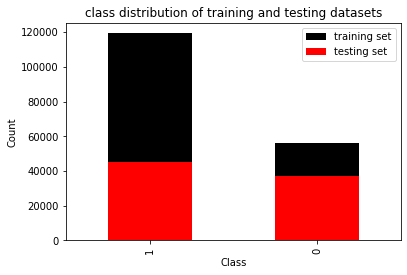

In [15]:
#Visualizing the class distribution
plt.figure()
plt.title("class distribution of training and testing datasets")
data['label'].value_counts().plot(kind="bar", color='k', label="training set")
test['label'].value_counts().plot(kind="bar", color='r', label="testing set")
plt.xlabel("Class")
plt.ylabel("Count")
plt.legend()
plt.show()

In [16]:
#Finding the counts of all datatypes in the dataset
data.dtypes.value_counts()

int64      30
float64    11
object      3
dtype: int64

In [17]:
#As already discovered, there are only 3 categorical features and they are - Service, Proto, and State
#Displaying value counts
data['service'].value_counts()

-           94168
dns         47294
http        18724
smtp         5058
ftp-data     3995
ftp          3428
ssh          1302
pop3         1105
dhcp           94
snmp           80
ssl            56
irc            25
radius         12
Name: service, dtype: int64

In [18]:
#Displaying value counts again
data['service'].value_counts()

-           94168
dns         47294
http        18724
smtp         5058
ftp-data     3995
ftp          3428
ssh          1302
pop3         1105
dhcp           94
snmp           80
ssl            56
irc            25
radius         12
Name: service, dtype: int64

In [19]:
#Allocating input or predictors to x
X_train, Y_train = data.drop(columns=['label']), data['label']
X_test, Y_test = test.drop(columns=['label']), test['label']
X_test.reset_index(drop=True, inplace=True)

In [20]:
test

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.090200,254,0,1.803636e+08,0.000000,0,0,0.011000,0.0,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,248,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.000300,254,0,8.810000e+08,0.000000,0,0,0.008000,0.0,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,881,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.005100,254,0,8.544000e+08,0.000000,0,0,0.005000,0.0,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,534,0,0,0,3,2,1,1,1,3,0,0,0,1,3,0,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.660800,254,0,6.000000e+08,0.000000,0,0,0.006000,0.0,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,450,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.002500,254,0,8.504000e+08,0.000000,0,0,0.010000,0.0,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,1063,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,82328,0.000005,udp,-,INT,2,0,104,0,200000.005100,254,0,8.320000e+07,0.000000,0,0,0.005000,0.0,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,52,0,0,0,1,2,2,1,1,2,0,0,0,2,1,0,0
82328,82329,1.106101,tcp,-,FIN,20,8,18062,354,24.410067,254,252,1.241044e+05,2242.109863,7,1,55.880051,143.7,4798.130981,190.980813,255,1072535109,3284291478,255,0.173208,0.100191,0.073017,903,44,0,0,1,1,2,1,1,1,0,0,0,3,2,0,0
82329,82330,0.000000,arp,-,INT,1,0,46,0,0.000000,0,0,0.000000e+00,0.000000,0,0,60000.720000,0.0,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,46,0,0,0,1,2,1,1,1,1,0,0,0,1,1,1,0
82330,82331,0.000000,arp,-,INT,1,0,46,0,0.000000,0,0,0.000000e+00,0.000000,0,0,60000.732000,0.0,10.954518,0.000000,0,0,0,0,0.000000,0.000000,0.000000,46,0,0,0,1,2,1,1,1,1,0,0,0,1,1,1,0


In [21]:
#Storing copies of categorical and numerical values
totalvalues = ['proto', 'service', 'state', 'label']
numericalvalues = list(set(data.columns) - set(totalvalues))

In [22]:
#Preprocessing of data - 
#Normalization using Min-Max scaler
scaler = MinMaxScaler()
scaler.fit(X_train[numericalvalues])
X_train[numericalvalues] = scaler.transform(X_train[numericalvalues])
X_test[numericalvalues] = scaler.transform(X_test[numericalvalues])

In [23]:
corr_matrix = X_train.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [24]:
print(to_drop)

['sbytes', 'dbytes', 'sloss', 'dloss', 'dwin', 'ct_src_dport_ltm', 'ct_dst_src_ltm', 'ct_ftp_cmd', 'ct_srv_dst']


In [25]:
X_test

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
0,0.000000,1.833334e-07,udp,-,INT,0.000104,0.000000,0.000036,0.000000,0.090909,0.996078,0.000000,0.030121,0.0000,0.000000,0.000000,1.303758e-07,0.000000,0.000000,0.00000,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.00000,0.149051,0.000000,0.0,0.0,0.016129,0.333333,0.00,0.00,0.0,0.015625,0.0,0.0,0.0,0.000000,0.016393,0.0
1,0.000006,1.333334e-07,udp,-,INT,0.000104,0.000000,0.000134,0.000000,0.125000,0.996078,0.000000,0.147128,0.0000,0.000000,0.000000,9.481875e-08,0.000000,0.000000,0.00000,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.00000,0.577913,0.000000,0.0,0.0,0.016129,0.333333,0.00,0.00,0.0,0.015625,0.0,0.0,0.0,0.000000,0.016393,0.0
2,0.000011,8.333335e-08,udp,-,INT,0.000104,0.000000,0.000080,0.000000,0.200000,0.996078,0.000000,0.142685,0.0000,0.000000,0.000000,5.926172e-08,0.000000,0.000000,0.00000,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.00000,0.342818,0.000000,0.0,0.0,0.032258,0.333333,0.00,0.00,0.0,0.031250,0.0,0.0,0.0,0.000000,0.032787,0.0
3,0.000017,1.000000e-07,udp,-,INT,0.000104,0.000000,0.000067,0.000000,0.166667,0.996078,0.000000,0.100200,0.0000,0.000000,0.000000,7.111406e-08,0.000000,0.000000,0.00000,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.00000,0.285908,0.000000,0.0,0.0,0.032258,0.333333,0.02,0.02,0.0,0.031250,0.0,0.0,0.0,0.016949,0.032787,0.0
4,0.000023,1.666667e-07,udp,-,INT,0.000104,0.000000,0.000162,0.000000,0.100000,0.996078,0.000000,0.142017,0.0000,0.000000,0.000000,1.185234e-07,0.000000,0.000000,0.00000,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.00000,0.701220,0.000000,0.0,0.0,0.032258,0.333333,0.02,0.02,0.0,0.031250,0.0,0.0,0.0,0.016949,0.032787,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,0.469528,8.333335e-08,udp,-,INT,0.000104,0.000000,0.000006,0.000000,0.200000,0.996078,0.000000,0.013894,0.0000,0.000000,0.000000,5.926172e-08,0.000000,0.000000,0.00000,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.00000,0.016260,0.000000,0.0,0.0,0.000000,0.333333,0.02,0.00,0.0,0.015625,0.0,0.0,0.0,0.016949,0.000000,0.0
82328,0.469533,1.843502e-02,tcp,-,FIN,0.001976,0.000729,0.001391,0.000024,0.000024,0.996078,0.992126,0.000021,0.0001,0.001457,0.000182,6.623096e-04,0.002534,0.003285,0.00066,1.0,0.24972,0.764699,1.0,0.068764,0.047702,0.04801,0.592818,0.030178,0.0,0.0,0.000000,0.166667,0.02,0.00,0.0,0.000000,0.0,0.0,0.0,0.033898,0.016393,0.0
82329,0.469539,0.000000e+00,arp,-,INT,0.000000,0.000000,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,7.111492e-01,0.000000,0.000000,0.00000,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.00000,0.012195,0.000000,0.0,0.0,0.000000,0.333333,0.00,0.00,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.0
82330,0.469545,0.000000e+00,arp,-,INT,0.000000,0.000000,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,7.111493e-01,0.000000,0.000008,0.00000,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.00000,0.012195,0.000000,0.0,0.0,0.000000,0.333333,0.00,0.00,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.0


In [26]:
X_train.drop(columns = to_drop, inplace = True)
X_test.drop(columns = to_drop, inplace = True)

In [27]:
serv = OneHotEncoder()
pro = OneHotEncoder()
sta = OneHotEncoder()

def encode(data):

    X = serv.fit_transform(data['service'].values.reshape(-1, 1))
    X2 = pro.fit_transform(data['proto'].values.reshape(-1, 1))
    X3 = sta.fit_transform(data['state'].values.reshape(-1, 1))

    data = pd.concat([data,
                      pd.DataFrame(X2.toarray(), columns=['proto_'+i for i in pro.categories_[0]]),
                      pd.DataFrame(X.toarray(), columns=['service_'+i for i in serv.categories_[0]]),
                      pd.DataFrame(X3.toarray(), columns=['state_'+i for i in sta.categories_[0]])],
                      axis=1)

    data.drop(['proto', 'service', 'state'], axis=1, inplace=True)

    return data

In [28]:
X_train = encode(X_train)
X_test = encode(X_test)

In [29]:
X_train

,id,dur,spkts,dpkts,rate,sttl,dttl,sload,dload,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_dst_sport_ltm,is_ftp_login,ct_flw_http_mthd,ct_src_ltm,is_sm_ips_ports,proto_3pc,proto_a/n,proto_aes-sp3-d,proto_any,proto_argus,proto_aris,proto_arp,proto_ax.25,proto_bbn-rcc,...,proto_tp++,proto_trunk-1,proto_trunk-2,proto_ttp,proto_udp,proto_unas,proto_uti,proto_vines,proto_visa,proto_vmtp,proto_vrrp,proto_wb-expak,proto_wb-mon,proto_wsn,proto_xnet,proto_xns-idp,proto_xtp,proto_zero,service_-,service_dhcp,service_dns,service_ftp,service_ftp-data,service_http,service_irc,service_pop3,service_radius,service_smtp,service_snmp,service_ssh,service_ssl,state_CON,state_ECO,state_FIN,state_INT,state_PAR,state_REQ,state_RST,state_URN,state_no
0,0.000000,2.024634e-03,0.000520,0.000364,0.000074,0.988235,1.000000,2.364553e-06,0.000379,2.879598e-04,0.000148,0.000021,0.000041,1.0,0.144768,0.512828,0.000000,0.000000,0.000000,0.010163,0.029492,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000006,1.083170e-02,0.001352,0.003463,0.000078,0.243137,0.992126,1.401989e-06,0.022458,5.916098e-04,0.000272,0.000042,0.004796,1.0,0.330128,0.716524,0.000000,0.000000,0.000000,0.016260,0.758573,0.0,0.0,0.677419,0.166667,0.00,0.000000,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000011,2.705215e-02,0.000728,0.001458,0.000014,0.243137,0.992126,2.625704e-07,0.002717,2.748269e-03,0.001811,0.011763,0.039466,1.0,0.492706,0.689918,0.044423,0.029261,0.033164,0.012195,0.565158,0.0,0.0,0.096774,0.166667,0.02,0.000000,0.00,0.0,0.016949,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000017,2.802737e-02,0.001144,0.001093,0.000014,0.243137,0.992126,4.576117e-07,0.000150,1.811945e-03,0.001591,0.000177,0.017249,1.0,0.257772,0.243882,0.000000,0.000000,0.000000,0.016260,0.043896,0.0,0.0,0.000000,0.166667,0.02,0.000000,0.25,0.0,0.016949,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000023,7.490901e-03,0.000936,0.000547,0.000033,0.996078,0.992126,1.429776e-06,0.000178,5.659534e-04,0.001334,0.001654,0.000400,1.0,0.567209,0.460351,0.050967,0.033874,0.037632,0.016938,0.030864,0.0,0.0,0.677419,0.166667,0.02,0.000000,0.00,0.0,0.016949,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175336,0.999977,1.500000e-07,0.000104,0.000000,0.111111,0.996078,0.000000,8.461366e-03,0.000000,1.066711e-07,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.019648,0.000000,0.0,0.0,0.370968,0.333333,0.46,0.266667,0.00,0.0,0.389831,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
175337,0.999983,8.429368e-03,0.000936,0.000729,0.000034,0.996078,0.992126

In [30]:
X_test

,id,dur,spkts,dpkts,rate,sttl,dttl,sload,dload,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_dst_sport_ltm,is_ftp_login,ct_flw_http_mthd,ct_src_ltm,is_sm_ips_ports,proto_3pc,proto_a/n,proto_aes-sp3-d,proto_any,proto_argus,proto_aris,proto_arp,proto_ax.25,proto_bbn-rcc,...,proto_tcp,proto_tlsp,proto_tp++,proto_trunk-1,proto_trunk-2,proto_ttp,proto_udp,proto_unas,proto_uti,proto_vines,proto_visa,proto_vmtp,proto_vrrp,proto_wb-expak,proto_wb-mon,proto_wsn,proto_xnet,proto_xns-idp,proto_xtp,proto_zero,service_-,service_dhcp,service_dns,service_ftp,service_ftp-data,service_http,service_irc,service_pop3,service_radius,service_smtp,service_snmp,service_ssh,service_ssl,state_ACC,state_CLO,state_CON,state_FIN,state_INT,state_REQ,state_RST
0,0.000000,1.833334e-07,0.000104,0.000000,0.090909,0.996078,0.000000,0.030121,0.0000,1.303758e-07,0.000000,0.000000,0.00000,0.0,0.00000,0.000000,0.000000,0.000000,0.00000,0.149051,0.000000,0.0,0.0,0.016129,0.333333,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.000006,1.333334e-07,0.000104,0.000000,0.125000,0.996078,0.000000,0.147128,0.0000,9.481875e-08,0.000000,0.000000,0.00000,0.0,0.00000,0.000000,0.000000,0.000000,0.00000,0.577913,0.000000,0.0,0.0,0.016129,0.333333,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.000011,8.333335e-08,0.000104,0.000000,0.200000,0.996078,0.000000,0.142685,0.0000,5.926172e-08,0.000000,0.000000,0.00000,0.0,0.00000,0.000000,0.000000,0.000000,0.00000,0.342818,0.000000,0.0,0.0,0.032258,0.333333,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.000017,1.000000e-07,0.000104,0.000000,0.166667,0.996078,0.000000,0.100200,0.0000,7.111406e-08,0.000000,0.000000,0.00000,0.0,0.00000,0.000000,0.000000,0.000000,0.00000,0.285908,0.000000,0.0,0.0,0.032258,0.333333,0.02,0.0,0.0,0.0,0.016949,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.000023,1.666667e-07,0.000104,0.000000,0.100000,0.996078,0.000000,0.142017,0.0000,1.185234e-07,0.000000,0.000000,0.00000,0.0,0.00000,0.000000,0.000000,0.000000,0.00000,0.701220,0.000000,0.0,0.0,0.032258,0.333333,0.02,0.0,0.0,0.0,0.016949,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,0.469528,8.333335e-08,0.000104,0.000000,0.200000,0.996078,0.000000,0.013894,0.0000,5.926172e-08,0.000000,0.000000,0.00000,0.0,0.00000,0.000000,0.000000,0.000000,0.00000,0.016260,0.000000,0.0,0.0,0.000000,0.333333,0.02,0.0,0.0,0.0,0.016949,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
82328,0.469533,1.843502e-02,0.001976,0.000729,0.000024,0.996078,0.992126,0.000021,0.0001,6.623096e-04,0.002534,0.003285,0.00066,1.0,0.24972,0.764699,0.068764,0.04

In [31]:
X_train, X_test = X_train.align(X_test, join='inner', axis=1)

In [32]:
class FalsePositiveRate(tf.keras.metrics.Metric):
    def __init__(self, name='false_positive_rate', **kwargs):
        super(FalsePositiveRate, self).__init__(name=name, **kwargs)
        self.negatives = self.add_weight(name='negatives', initializer='zeros')
        self.false_positives = self.add_weight(name='false_negatives', initializer='zeros')
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.bool)
        
        negatives = tf.reduce_sum(tf.cast(tf.equal(y_true, False), self.dtype))
        
        self.negatives.assign_add(negatives)
        
        y_pred = tf.greater_equal(y_pred, 0.5)
        
        false_positive_values = tf.logical_and(tf.equal(y_true, False), tf.equal(y_pred, True)) 
        false_positive_values = tf.cast(false_positive_values, self.dtype)
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, self.dtype)
            sample_weight = tf.broadcast_weights(sample_weight, values)
            values = tf.multiply(false_positive_values, sample_weight)
        
        false_positives = tf.reduce_sum(false_positive_values)
        
        self.false_positives.assign_add(false_positives)
        
    def result(self):
        return tf.divide(self.false_positives, self.negatives)

In [33]:
def plot_loss(model_history):
  train_loss=[value for key, value in model_history.items() if 'loss' in key.lower()][0]
  valid_loss=[value for key, value in model_history.items() if 'loss' in key.lower()][1]
  fig, ax1 = plt.subplots()
  color = 'tab:blue'
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss', color=color)
  ax1.plot(train_loss, '--', color=color, label='Train Loss')
  ax1.plot(valid_loss, color=color, label='Valid Loss')
  ax1.tick_params(axis='y', labelcolor=color)
  plt.legend(loc='upper left')
  plt.title('Model Loss')
  plt.show()

def plot_model_recall_fpr(model_history):
  train_recall=[value for key, value in model_history.items() if 'recall' in key.lower()][0]
  valid_recall=[value for key, value in model_history.items() if 'recall' in key.lower()][1]
  train_fpr=[value for key, value in model_history.items() if 'false_positive_rate' in key.lower()][0]
  valid_fpr=[value for key, value in model_history.items() if 'false_positive_rate' in key.lower()][1]
  fig, ax1 = plt.subplots()
  color = 'tab:red'
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Recall', color=color)
  ax1.set_ylim([-0.05,1.05])
  ax1.plot(train_recall, '--', color=color, label='Train Recall')
  ax1.plot(valid_recall, color=color, label='Valid Recall')
  ax1.tick_params(axis='y', labelcolor=color)
  plt.legend(loc='upper left')
  plt.title('Model Recall and FPR')
  ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
  color = 'tab:blue'
  ax2.set_ylabel('False Positive Rate', color=color)  # we already handled the x-label with ax1
  ax2.plot(train_fpr, '--', color=color, label='Train FPR')
  ax2.plot(valid_fpr, color=color, label='Valid FPR')
  ax2.tick_params(axis='y', labelcolor=color)
  ax2.set_ylim([-0.05,1.05])
  fig.tight_layout()  # otherwise the right y-label is slightly clipped
  plt.legend(loc='upper right')
  plt.show()

In [34]:
mlp = Sequential()
mlp.add(Dense(units=30, input_dim=X_train.shape[1], activation='relu'))
mlp.add(Dense(1, activation='sigmoid'))
mlp.summary()
mlp.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy', FalsePositiveRate(), tf.keras.metrics.Recall()]
           )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                5430      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 5,461
Trainable params: 5,461
Non-trainable params: 0
_________________________________________________________________


In [35]:
history = mlp.fit(x=X_train,
                  y=Y_train,
                  batch_size=5000,
                  epochs=100,validation_split = 0.2,
                  verbose=0).history

In [36]:
test_results = mlp.evaluate(X_test, Y_test, verbose=1)
print(f'Test results -  Accuracy: {test_results[1]*100}')

2573/2573 [==============================] - 3s 1ms/step - loss: 0.4474 - accuracy: 0.7430 - false_positive_rate: 0.3427 - recall: 0.8130
Test results -  Accuracy: 74.30160641670227


In [37]:
print(f'Test results -  Accuracy: {test_results[1]*100}')

Test results -  Accuracy: 74.30160641670227


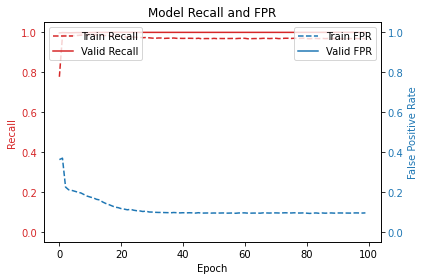

In [38]:
plot_model_recall_fpr(history)